This script cleans data in the original "HMDB_simp" folder and outputs a new folder of the same structure called "HMDB_simp_clean".  
1. Run the "Clean Data" section
2. The EDA section has some checks and visualisations showing the changes between the folders


Main checks and results:
- same number of classes (25) and subfolders (50)
- number of files in each subfolder either decreases or remains the same
- significant outliers are removed, dataset is more evenly distributed (shown by boxplot)
- classes with most duplicates removed: brush_hair, pour, kiss, climb, shoot_bow

### Clean Data

In [6]:
import os
import shutil
import torch
from torchvision.io import read_image
from tqdm import tqdm
import hashlib

# Converts a tensor to bytes and returns an MD5 hash string for exact duplicates. 
# This gives a unique identifier for the image's exact pixel values.
def get_tensor_hash(tensor):
    return hashlib.md5(tensor.numpy().tobytes()).hexdigest()

# Source and destination folders
source_root = 'HMDB_simp'
destination_root = 'HMDB_simp_clean'

# Iterate through each class 
for class_name in tqdm(os.listdir(source_root), desc='Processing classes'):
    class_path = os.path.join(source_root, class_name)
    if not os.path.isdir(class_path):
        continue
        
    # Iterate through each subfolder 
    for video_name in os.listdir(class_path):
        video_path = os.path.join(class_path, video_name)
        if not os.path.isdir(video_path):
            continue
            
        # Create the corresponding folder in the cleaned dataset path
        dest_video_path = os.path.join(destination_root, class_name, video_name)
        os.makedirs(dest_video_path, exist_ok=True)

        seen_hashes = set() # To store hashes of unique image
        
        # Loop through all .jpg files in the video folder
        for filename in sorted(os.listdir(video_path)):
            if not filename.lower().endswith('.jpg'):
                continue

            file_path = os.path.join(video_path, filename)
            try:
                tensor = read_image(file_path)  # Read image as a tensor of shape [C, H, W], dtype=torch.uint8
                tensor_hash = get_tensor_hash(tensor) # Get tensor hash to check for duplicates

                # If this hash hasn’t been seen before, save and copy the image to clean dataset folder
                if tensor_hash not in seen_hashes:
                    seen_hashes.add(tensor_hash)
                    shutil.copy2(file_path, os.path.join(dest_video_path, filename))
            except Exception as e:
                print(f"Error processing {file_path}: {e}")


Processing classes: 100%|███████████████████████| 26/26 [03:58<00:00,  9.18s/it]


### EDA

In [25]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import numpy as np

In [14]:
DATASET_PATH_old = "./data/HMDB_simp"
DATASET_PATH_new = "./data/HMDB_simp_clean"

In [15]:
#Check that the number of classes is 25
classes_old = [c for c in os.listdir(DATASET_PATH_old) if not c.startswith('.') and os.path.isdir(os.path.join(DATASET_PATH_old, c))]
classes_new = [c for c in os.listdir(DATASET_PATH_new) if not c.startswith('.') and os.path.isdir(os.path.join(DATASET_PATH_new, c))]

len(classes_new), len(classes_old)==len(classes_new)

(25, True)

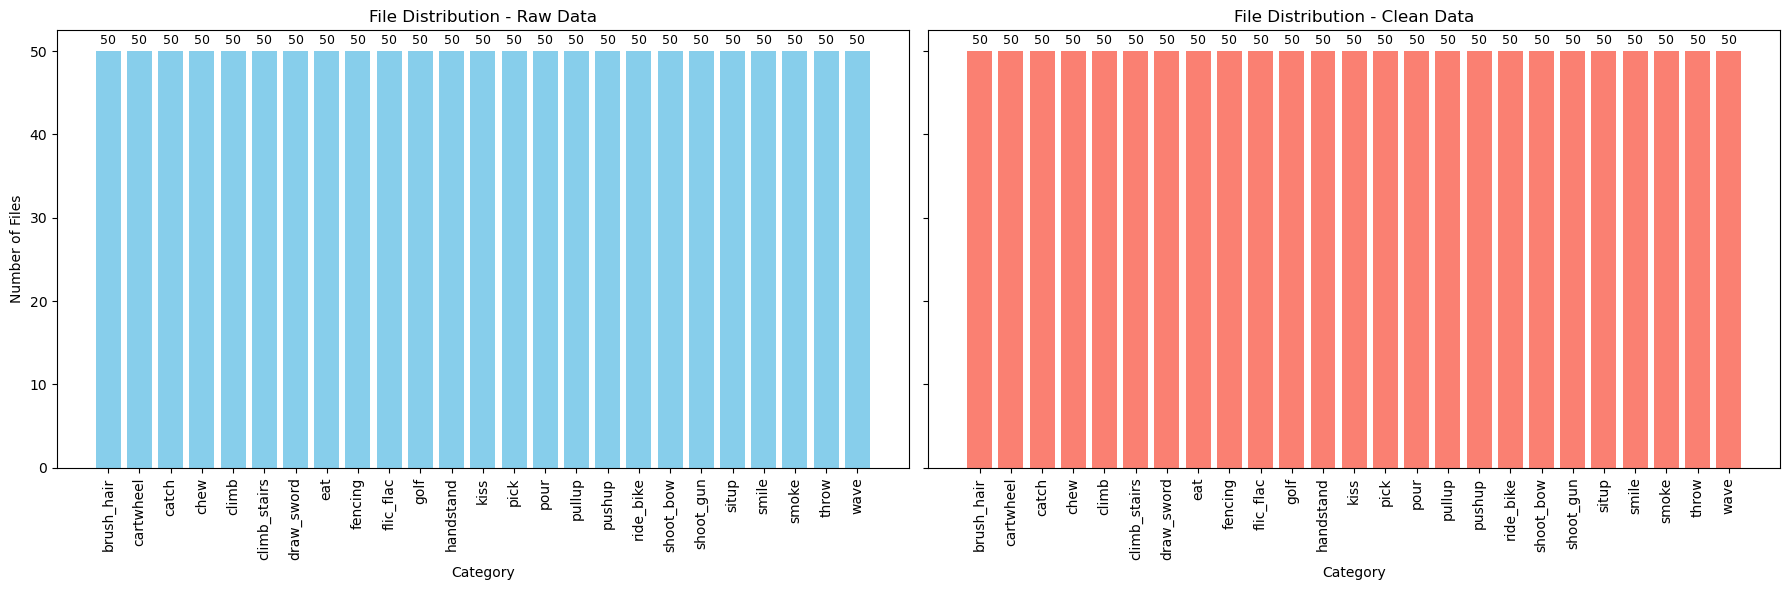

In [16]:
#Check that the number of videos per class is 50

def get_category_counts(dataset_path, classes):
    categories = []
    folder_counts = []

    for c in classes:
        folder_path = os.path.join(dataset_path, c)
        total_files = len([f for f in os.listdir(folder_path) if not f.startswith('.')])
        categories.append(c)
        folder_counts.append(total_files)
    
    sorted_categories, sorted_counts = zip(*sorted(zip(categories, folder_counts)))
    return sorted_categories, sorted_counts

# Define dataset paths and class labels
classes = sorted([
    d for d in os.listdir(DATASET_PATH_old)
    if os.path.isdir(os.path.join(DATASET_PATH_old, d)) and not d.startswith('.')
])

# Get file counts for each dataset
sorted_categories_old, sorted_counts_old = get_category_counts(DATASET_PATH_old, classes)
sorted_categories_new, sorted_counts_new = get_category_counts(DATASET_PATH_new, classes)

# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Old dataset
axes[0].bar(sorted_categories_old, sorted_counts_old, color='skyblue')
axes[0].set_title("File Distribution - Raw Data")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Number of Files")
axes[0].tick_params(axis='x', rotation=90)
for i, count in enumerate(sorted_counts_old):
    axes[0].text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=9)

# New dataset
axes[1].bar(sorted_categories_new, sorted_counts_new, color='salmon')
axes[1].set_title("File Distribution - Clean Data")
axes[1].set_xlabel("Category")
axes[1].tick_params(axis='x', rotation=90)
for i, count in enumerate(sorted_counts_new):
    axes[1].text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [18]:
#create combined dataframe of old and new data for comparison 

def get_frame_counts(dataset_path, classes):
    subfolders = []
    file_counts = []
    class_name = []

    for c in classes:
        folder_path = os.path.join(dataset_path, c)
        if not os.path.isdir(folder_path):
            continue

        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                subfolder_files = len([
                    f for f in os.listdir(subfolder_path)
                    if not f.startswith('.')
                ])

                subfolders.append(f"{c}/{subfolder}")
                file_counts.append(subfolder_files)
                class_name.append(c)

    return pd.DataFrame({
        "Class": class_name,
        "Subfolder": subfolders,
        "File Count": file_counts
    })

# Filter class folders
classes = sorted([
    d for d in os.listdir(DATASET_PATH_old)
    if os.path.isdir(os.path.join(DATASET_PATH_old, d)) and not d.startswith('.')
])

# Get DataFrames for both datasets
df_old = get_frame_counts(DATASET_PATH_old, classes)
df_new = get_frame_counts(DATASET_PATH_new, classes)

# Merge the two DataFrames into one combined DataFrame
df_combined = pd.merge(df_old, df_new, on="Subfolder", suffixes=('_raw', '_clean'))
df_combined = df_combined.drop(columns=["Class_clean"]).rename(columns={"Class_raw": "Class"})

#Add other columns
df_combined['difference'] = df_combined['File Count_raw'] - df_combined['File Count_clean']
df_combined['increased'] = df_combined['File Count_raw'] < df_combined['File Count_clean']

df_combined

,Class,Subfolder,File Count_raw,File Count_clean,difference,increased
0,brush_hair,brush_hair/1D650A30,405,286,119,False
1,brush_hair,brush_hair/FF04A83A,263,261,2,False
2,brush_hair,brush_hair/69A226C4,82,82,0,False
3,brush_hair,brush_hair/D35489FB,142,142,0,False
4,brush_hair,brush_hair/35272483,294,270,24,False
...,...,...,...,...,...,...
1245,wave,wave/9EB7530B,194,194,0,False
1246,wave,wave/BDE086A6,95,95,0,False
1247,wave,wave/2BB1CD1D,203,203,0,False
1248,wave,wave/760E2F4E,79,79,0,False


In [19]:
#check the number of folders hasn't increased
sum(df_combined['increased']) 

0

In [21]:
#Total duplicates removed per class
total_original = df_combined.groupby("Class")["File Count_raw"].sum()
total_clean = df_combined.groupby("Class")["File Count_clean"].sum()
total_removed = df_combined.groupby("Class")["difference"].sum()

#Number of classes where duplicates were actually removed
folders_with_dupes = df_combined[df_combined["difference"] > 0]["Class"].value_counts()

#Combine into a summary DataFrame
summary = pd.DataFrame({
    "Total Raw Files": total_original,
    "Total Clean Files": total_clean,
    "Total Files Removed": total_removed,
    "% Files Removed": total_removed*100/total_clean,
    "Folders With Duplicates Removed": folders_with_dupes
}).fillna(0).astype(int)  # fill NaNs with 0 and make int
summary = summary.sort_values("Total Files Removed", ascending=False)

summary

,Total Raw Files,Total Clean Files,Total Files Removed,% Files Removed,Folders With Duplicates Removed
Class,,,,,
brush_hair,13250,11695,1555,13,23
pour,8551,7178,1373,19,12
kiss,9001,8000,1001,12,10
climb,8137,7203,934,12,17
shoot_bow,8777,8111,666,8,20
smoke,7250,7119,131,1,9
shoot_gun,4708,4622,86,1,12
pick,4437,4390,47,1,9
throw,4951,4913,38,0,10


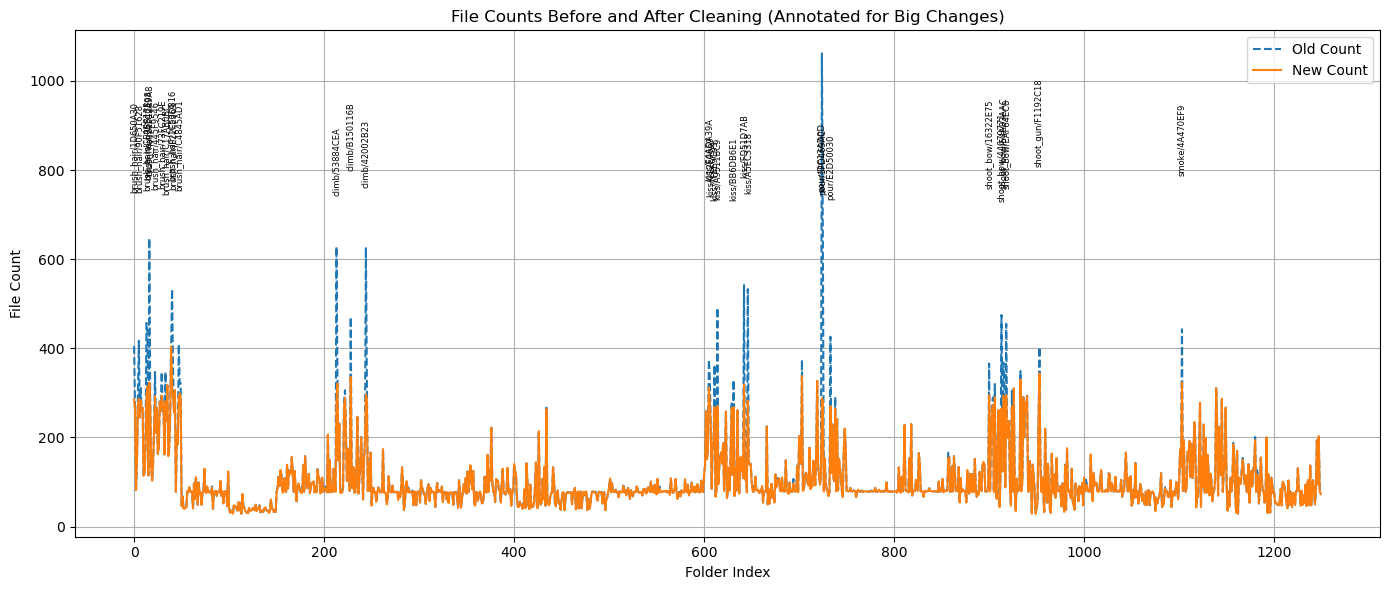

In [22]:
#visualise changes in frame count per video

plt.figure(figsize=(14, 6))
plt.plot(df_combined["File Count_raw"], label="Old Count", linestyle='--')
plt.plot(df_combined["File Count_clean"], label="New Count", linestyle='-')

# Annotate folders with > 50 files removed
for idx, row in df_combined[df_combined["difference"] > 50].iterrows():
    plt.annotate(row["Subfolder"], 
                 (idx, row["File Count_clean"]),
                 textcoords="offset points", 
                 xytext=(0, 150), 
                 ha='center', 
                 fontsize=6, rotation=90)

plt.title("File Counts Before and After Cleaning (Annotated for Big Changes)")
plt.xlabel("Folder Index")
plt.ylabel("File Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


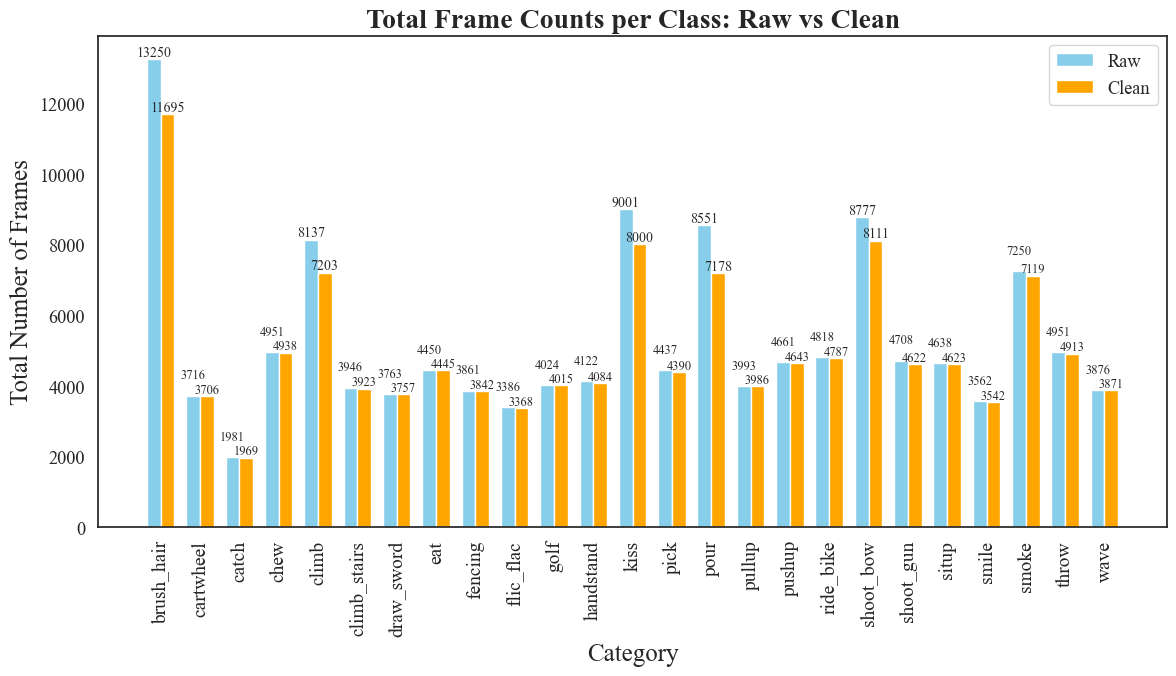

In [69]:
#total frame counts per class - old vs new

def get_class_totals(dataset_path, classes):
    class_totals = {c: 0 for c in classes}
    
    for c in classes:
        folder_path = os.path.join(dataset_path, c)
        if not os.path.isdir(folder_path):
            continue

        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                subfolder_files = len([
                    f for f in os.listdir(subfolder_path)
                    if not f.startswith('.')
                ])
                class_totals[c] += subfolder_files

    return class_totals

# Get list of classes
classes = sorted([
    d for d in os.listdir(DATASET_PATH_old)
    if os.path.isdir(os.path.join(DATASET_PATH_old, d)) and not d.startswith('.')
])

# Get totals
totals_old = get_class_totals(DATASET_PATH_old, classes)
totals_new = get_class_totals(DATASET_PATH_new, classes)

# Create DataFrame
df_totals = pd.DataFrame({
    "Class": classes,
    "Raw": [totals_old[c] for c in classes],
    "Clean": [totals_new[c] for c in classes]
})

# Plot
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(12, 7))
bars1 = plt.bar(x - width/2, df_totals["Raw"], width, label='Raw', color='skyblue')
bars2 = plt.bar(x + width/2, df_totals["Clean"], width, label='Clean', color='orange')

# Add labels with better offset logic to prevent overlap
for b1, b2 in zip(bars1, bars2):
    h1 = b1.get_height()
    h2 = b2.get_height()
    x1 = b1.get_x() + b1.get_width() / 2
    x2 = b2.get_x() + b2.get_width() / 2
    
    if abs(h1 - h2) < 150:
        # Very close heights → nudge them apart clearly
        plt.text(x1, h1 + 400, str(int(h1)), ha='center', va='bottom', fontsize=9)
        plt.text(x2, h2, str(int(h2)), ha='center', va='bottom', fontsize=9)
    else:
        # Normal spacing
        plt.text(x1, h1 + 2, str(int(h1)), ha='center', va='bottom', fontsize=10)
        plt.text(x2, h2 + 2, str(int(h2)), ha='center', va='bottom', fontsize=10)

# Aesthetics
plt.xlabel("Category", fontsize=18)
plt.ylabel("Total Number of Frames", fontsize=18)
plt.title("Total Frame Counts per Class: Raw vs Clean", fontsize=20,weight='bold')
plt.xticks(x, classes, rotation=90, fontsize=14)
plt.legend()
plt.tight_layout()

plt.savefig("bar_frame_count_comparison.png", dpi=300) 
plt.show()



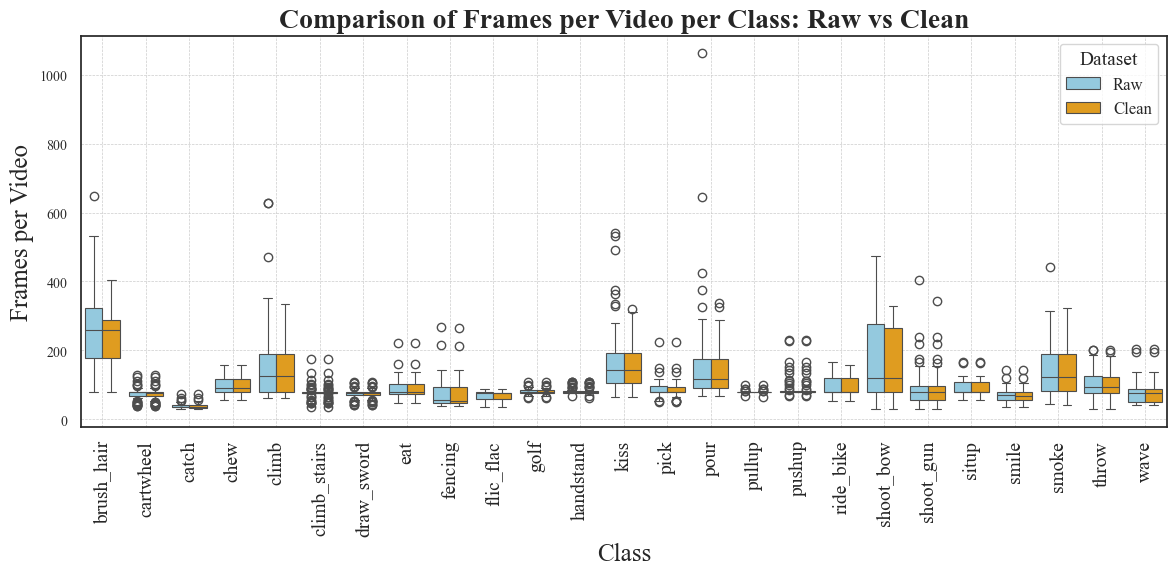

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style and font
sns.set_style("white")
plt.rcParams["font.family"] = "Times New Roman"

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_long,
    x="Class",
    y="File Count",
    hue="Dataset",
    palette=["skyblue", "orange"],
    linewidth=0.8  # Thinner boxes
)

# Title and axis labels
plt.title("Comparison of Frames per Video per Class: Raw vs Clean", fontsize=20, weight="bold")
plt.xlabel("Class", fontsize=18)
plt.ylabel("Frames per Video", fontsize=18)

# Tick label size
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=10)

plt.grid(True, linestyle='--', linewidth=0.5)

# Legend
plt.legend(title="Dataset", title_fontsize=14, fontsize=12, loc="upper right")

# Save the plot
plt.tight_layout()
plt.savefig("boxplot_comparison_raw_clean.png", dpi=300)  # Save as PDF with high resolution

plt.show()
